In [ ]:
#1. 数据爬取部分
import scrapy
from scrapy.crawler import CrawlerProcess
import pandas as pd
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import time
import random

class BitcoinScraper(scrapy.Spider):
    name = 'bitcoin_scraper'
    custom_settings = {
        'USER_AGENT': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3',
        'DOWNLOAD_DELAY': 2,
        'CONCURRENT_REQUESTS_PER_DOMAIN': 1
    }
    
    def start_requests(self):
        base_url = "https://www.bijienews.com/market/bitcoin_usd.html"
        yield scrapy.Request(url=base_url, callback=self.parse)
    
    def parse(self, response):
        # 解析表格数据
        table = response.xpath('//table[@class="table table-striped table-hover"]')
        headers = table.xpath('.//thead/tr/th/text()').getall()
        rows = table.xpath('.//tbody/tr')
        
        data = []
        for row in rows:
            cells = row.xpath('.//td/text()').getall()
            if len(cells) == len(headers):
                item = dict(zip(headers, cells))
                # 转换日期格式
                try:
                    item['日期'] = datetime.strptime(item['日期'], '%Y/%m/%d').strftime('%Y/%m/%d')
                except:
                    pass
                data.append(item)
        
        # 保存到Excel
        df = pd.DataFrame(data)
        df.to_excel('bitcoin_price_data.xlsx', index=False)
        self.log(f'Saved {len(df)} records to bitcoin_price_data.xlsx')

# 运行爬虫
process = CrawlerProcess()
process.crawl(BitcoinScraper)
process.start()


process.crawl(BitcoinScraper)
process.start()

In [31]:
#2. 数据清洗与预处理
import pandas as pd
import numpy as np

def load_and_clean_data(file_path):
    # 加载数据
    df = pd.read_excel(file_path)
    
    # 数据清洗
    # 转换日期列
    df['日期'] = pd.to_datetime(df['日期'], errors='coerce')  # 使用errors='coerce'将无法解析的日期转换为NaT
    df = df.dropna(subset=['日期']).sort_values('日期').reset_index(drop=True)  # 删除日期为NaT的行并排序
    
    # 处理缺失值
    numeric_cols = ['收盘价', '开盘价', '最高价', '最低价', '交易量', '涨跌幅']
    for col in numeric_cols:
        # 尝试转换为数值类型，无法转换的变为NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # 前向填充缺失值（这里假设连续的数据点中，前一个值对后一个值有参考价值）
        df[col].fillna(method='ffill', inplace=True)
        # 如果仍有缺失值（如数据开头），使用线性插值
        df[col].interpolate(method='linear', inplace=True)
    
    # 计算日收益率
    df['日收益率'] = df['收盘价'].pct_change()
    
    # 计算波动率（这里使用收盘价计算价格变动和波动率）
    df['价格变动'] = df['收盘价'].diff()
    # 避免除以0的情况，使用rolling的mean时，先检查是否有足够的非NaN值
    df['波动率'] = df['价格变动'].rolling(window=7, min_periods=1).std() / df['收盘价'].rolling(window=7, min_periods=1).mean()
    
    return df

# 使用示例
df = load_and_clean_data(r"C:\Users\GJ\OneDrive\Desktop\bitcoin_price_data.xlsx")
print(df.head())

2025-05-22 13:44:00 [py.warnings] WARNING: C:\Users\GJ\AppData\Local\Temp\ipykernel_18712\1264697040.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(method='ffill', inplace=True)

2025-05-22 13:44:00 [py.warnings] WARNING: C:\Users\GJ\AppData\Local\Temp\ipykernel_18712\1264697040.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col].fillna(method='ffill', inplace=True)

2025-05-22 13:44:00 [py.warnings] WARNING: 

          日期     收盘价    开盘价     最高价    最低价      交易量     涨跌幅      日收益率  价格变动  \
0 2014-01-01   815.9  805.9   829.9  771.0  10760.0  0.0124       NaN   NaN   
1 2014-01-02   856.9  815.9   886.2  810.5  12810.0  0.0502  0.050251  41.0   
2 2014-01-03   884.3  856.9   888.2  839.4   9710.0  0.0319  0.031976  27.4   
3 2014-01-04   924.7  884.3   932.2  848.3  14240.0  0.0457  0.045686  40.4   
4 2014-01-05  1014.7  924.7  1029.9  911.4  21370.0  0.0974  0.097329  90.0   

        波动率  
0       NaN  
1       NaN  
2  0.011282  
3  0.008828  
4  0.030679  


基本统计量:
                 收盘价            开盘价           最高价            最低价  \
count    4071.000000    4071.000000    4071.00000    4071.000000   
mean    19398.860599   19375.454925   19822.20759   18907.323753   
std     23600.135281   23571.056049   24075.49781   23054.824526   
min       111.600000     111.600000     160.10000      91.700000   
25%       740.350000     740.350000     751.65000     727.400000   
50%      8783.100000    8778.100000    8986.20000    8541.600000   
75%     30184.250000   30153.300000   30647.90000   29601.100000   
max    106157.200000  106157.200000  109228.60000  105350.600000   

                 交易量          涨跌幅  
count    4071.000000  4071.000000  
mean   190967.624662     0.002563  
std    233428.483833     0.068692  
min       260.000000    -0.572100  
25%     46530.000000    -0.012900  
50%     87490.000000     0.000900  
75%    233450.000000     0.016900  
max    999530.000000     3.368400  


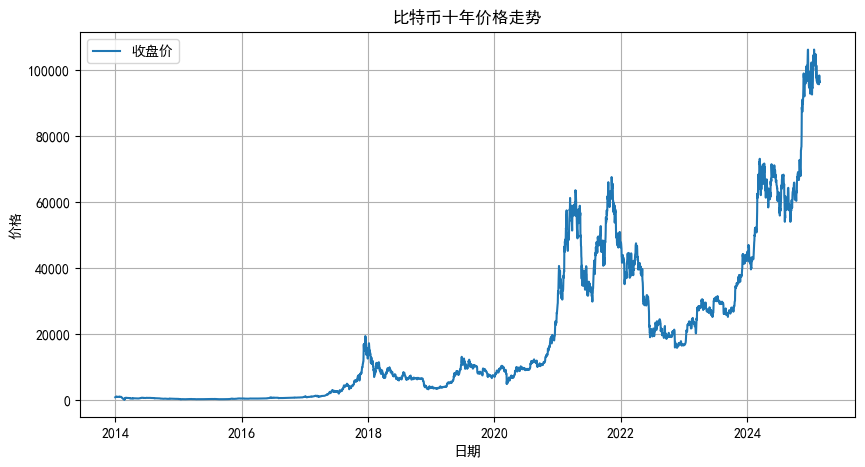

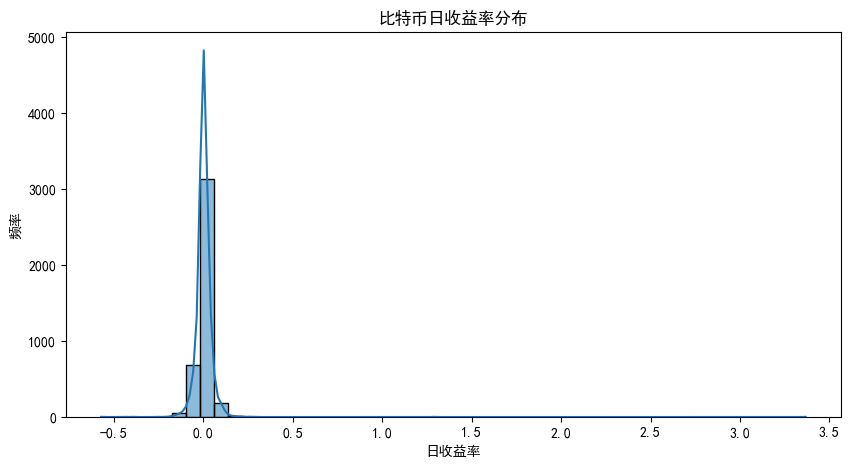

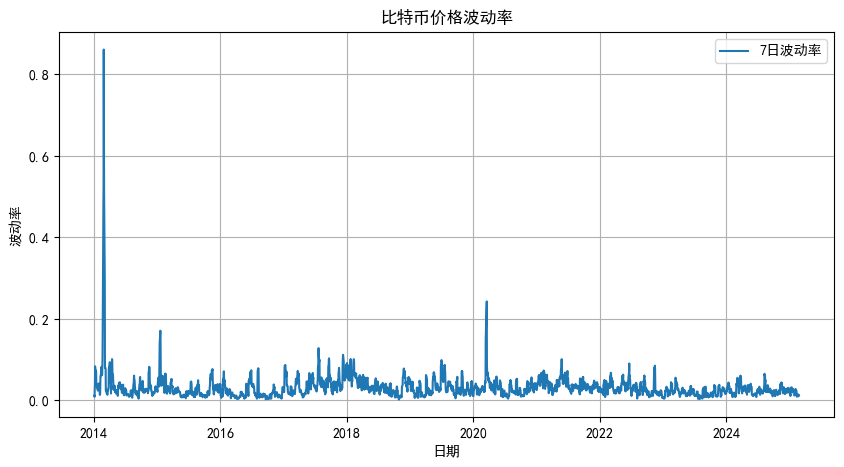

In [41]:
#3. 描述性统计分析
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# 设置中文字体
rcParams['font.sans-serif'] = ['SimHei']  # Windows系统常用黑体

# 解决负号显示问题
rcParams['axes.unicode_minus'] = False

def descriptive_analysis(df):
    # 基本统计量
    print("基本统计量:")
    print(df[['收盘价', '开盘价', '最高价', '最低价', '交易量', '涨跌幅']].describe())
    
    # 价格走势图
    plt.figure(figsize=(10, 5))
    plt.plot(df['日期'], df['收盘价'], label='收盘价')
    plt.title('比特币十年价格走势')
    plt.xlabel('日期')
    plt.ylabel('价格')
    plt.legend()
    plt.grid()
    plt.show()
    
    # 收益率分布
    plt.figure(figsize=(10, 5))
    sns.histplot(df['日收益率'].dropna(), bins=50, kde=True)
    plt.title('比特币日收益率分布')
    plt.xlabel('日收益率')
    plt.ylabel('频率')
    plt.show()
    
    # 波动率分析
    plt.figure(figsize=(10, 5))
    plt.plot(df['日期'], df['波动率'], label='7日波动率')
    plt.title('比特币价格波动率')
    plt.xlabel('日期')
    plt.ylabel('波动率')
    plt.legend()
    plt.grid()
    plt.show()

# 使用示例
descriptive_analysis(df)

In [48]:
!pip install arch

Defaulting to user installation because normal site-packages is not writeable


Iteration:      5,   Func. Count:     33,   Neg. LLF: 10838.159806429032
Iteration:     10,   Func. Count:     58,   Neg. LLF: 10825.804418310698
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10825.804418309537
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   日收益率   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10825.8
Distribution:                  Normal   AIC:                           21659.6
Method:            Maximum Likelihood   BIC:                           21684.9
                                        No. Observations:                 4070
Date:                Thu, May 22 2025   Df Residuals:                     4069
Time:       

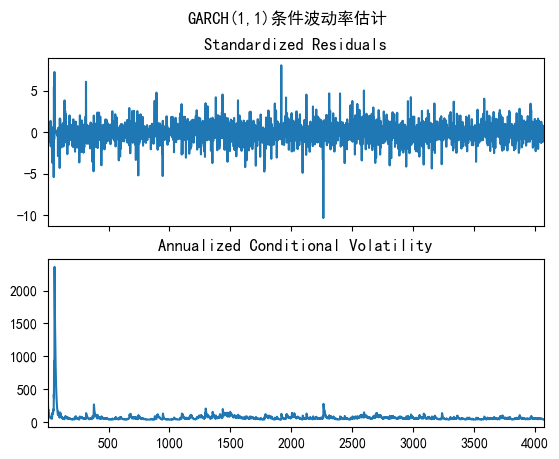

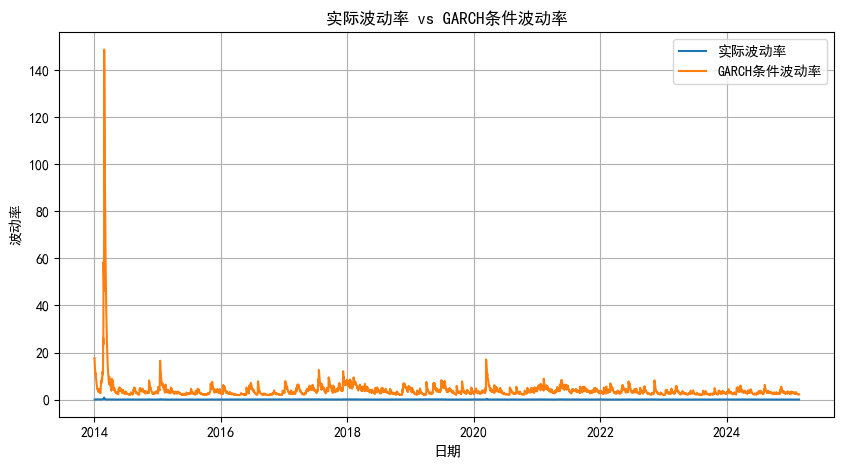

In [53]:
#4.波动率分析
import matplotlib.pyplot as plt
from arch import arch_model

def volatility_analysis(df):
    # 确保日期列是datetime类型
    df['日期'] = pd.to_datetime(df['日期'])
    
    # 计算历史波动率
    returns = df['日收益率'].dropna() * 100  # 转换为百分比
    
    # GARCH(1,1)模型
    garch = arch_model(returns, vol='Garch', p=1, q=1)
    garch_fit = garch.fit(update_freq=5)
    print(garch_fit.summary())
    
    # 绘制条件波动率
    fig = garch_fit.plot(annualize='D')
    plt.suptitle('GARCH(1,1)条件波动率估计')
    plt.show()
    
    # 波动率聚类分析
    plt.figure(figsize=(10, 5))
    
    # 确保长度匹配
    start_idx = len(df) - len(returns)
    actual_vol = df['波动率'].iloc[start_idx:] if len(df['波动率']) > len(returns) else df['波动率']
    
    plt.plot(df['日期'].iloc[start_idx:], actual_vol, label='实际波动率')
    plt.plot(df['日期'].iloc[start_idx:], garch_fit.conditional_volatility, label='GARCH条件波动率')
    plt.title('实际波动率 vs GARCH条件波动率')
    plt.xlabel('日期')
    plt.ylabel('波动率')
    plt.legend()
    plt.grid()
    plt.show()

volatility_analysis(df) 

主要周期: 0.00 天


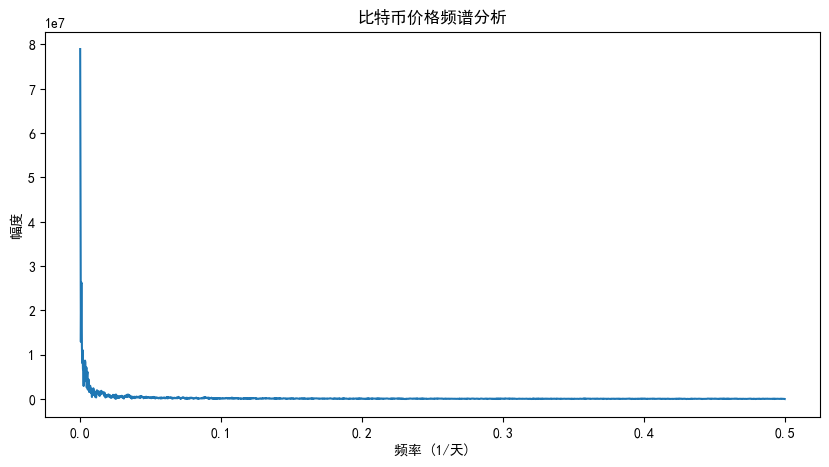

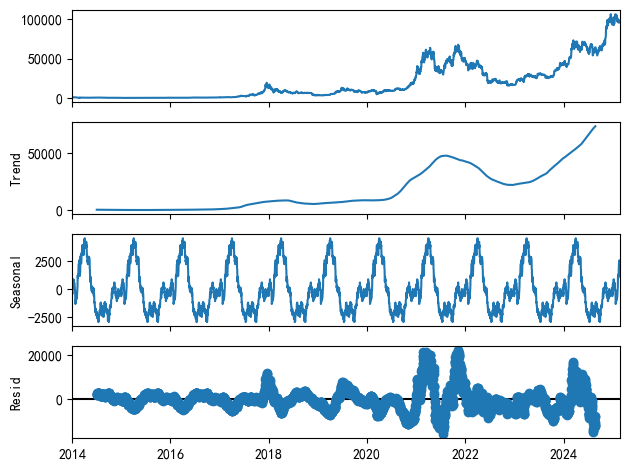

In [65]:
#5. 周期性分析
from scipy import fftpack
import statsmodels.api as sm

def periodicity_analysis(df):
    # 傅里叶变换分析
    price = df['收盘价'].values
    N = len(price)
    T = 1  # 每日数据
    
    # 傅里叶变换
    fft = fftpack.fft(price)
    freqs = fftpack.fftfreq(len(price), T)
    
    # 只取正频率部分
    positive_freqs = freqs[:N//2]
    magnitudes = np.abs(fft[:N//2])
    
    # 找出主要频率
    main_freq = positive_freqs[np.argmax(magnitudes)]
    main_period = 1 / main_freq if main_freq != 0 else 0
    print(f"主要周期: {main_period:.2f} 天")
    
    # 绘制频谱
    plt.figure(figsize=(10, 5))
    plt.plot(positive_freqs, magnitudes)
    plt.title('比特币价格频谱分析')
    plt.xlabel('频率 (1/天)')
    plt.ylabel('幅度')
    plt.show()
    
    # 季节性分解
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    # 确保数据没有缺失值
    df_seasonal = df.set_index('日期')[['收盘价']].dropna()
    
    # 假设年度季节性 (365天)
    try:
        decomposition = seasonal_decompose(df_seasonal, model='additive', period=365)
        decomposition.plot()
        plt.show()
    except:
        print("无法进行季节性分解 - 数据可能太短或周期不合适")

# 使用示例
periodicity_analysis(df)

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA模型摘要:
                               SARIMAX Results                                
Dep. Variable:                    收盘价   No. Observations:                 4071
Model:                 ARIMA(8, 1, 2)   Log Likelihood              -33569.006
Date:                Thu, 22 May 2025   AIC                          67160.012
Time:                        21:20:10   BIC                          67229.438
Sample:                             0   HQIC                         67184.600
                               - 4071                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2272      0.010    -21.658      0.000      -0.248      -0.207
ar.L2         -0.9430      0.011    -87.542      0.000      -0.964      -0.922
ar.L3         -0.0358      0.012     -2.8

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


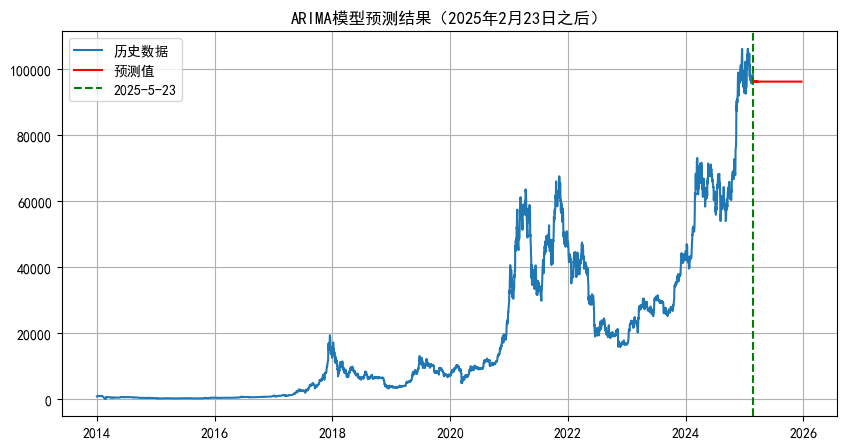

In [71]:
#6. 预测模型构建   ARIMA模型
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

def arima_model(file_path):
    # 读取Excel文件
    df = pd.read_excel(file_path)
    
    # 确保日期列存在并正确转换为datetime
    if '日期' in df.columns:
        df['日期'] = pd.to_datetime(df['日期'])
        df = df.set_index('日期')
    
    # 准备数据
    data = df['收盘价']
    
    # 拟合ARIMA模型
    try:
        # 这里使用ARIMA(8,1,2)作为模型
        model = ARIMA(data, order=(8,1,2))
        model_fit = model.fit()
        
        print("ARIMA模型摘要:")
        print(model_fit.summary())
        
        # 预测到2025年12月20日（例如，预测300天）
        last_date = data.index[-1]
        forecast_steps = 300  # 可以根据需要调整预测天数
        forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)
        
        # 生成预测
        forecast = model_fit.forecast(steps=forecast_steps)
        
        # 可视化
        plt.figure(figsize=(10, 5))
        plt.plot(data.index, data, label='历史数据')
        plt.plot(forecast_index, forecast, label='预测值', color='red')
        plt.title('ARIMA模型预测结果（2025年2月23日之后）')
        plt.legend()
        plt.grid()
        plt.axvline(x=datetime(2025, 2, 23), color='g', linestyle='--', label='2025-5-23')
        plt.legend()
        plt.show()
        
        return model_fit
    
    except Exception as e:
        print(f"模型拟合出错: {str(e)}")
        return None

# 示例使用
if __name__ == "__main__":
    # 指定Excel文件路径
    file_path = r"C:\Users\GJ\OneDrive\Desktop\bitcoin_price_data.xlsx"
    
    # 调用函数
    arima_model(file_path)

In [11]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB 495.5 kB/s eta 0:00:27
   ---------------------------------------- 0.1/13.3 MB 563.7 kB/s eta 0:00:24
   ---------------------------------------- 0.1/13.3 MB 585.1 kB/s eta 0:00:23
   ---------------------------------------- 0.1/13.3 MB 585.1 kB/s eta 0:00:23
   ---------------------------------------- 0.2/13.3 MB 573.4 kB/s eta 0:00:23
    --------------------------------------- 0.2/13.3 MB 583.1 kB/s eta 0:00:23
    --------------------------------------- 0.2/13.3 MB 557.9 kB/s eta 0:00:24
    --------------------------------------- 0.2/13.3 MB 557.9 kB/s eta 0:00:24
    --------------------------------------- 0.2/13.3 MB 529.7 kB/s eta 0:00:25
    --------------------------------------- 0.2/13.3 MB 497.3 kB/s eta 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


21:36:44 - cmdstanpy - INFO - Chain [1] start processing
21:36:45 - cmdstanpy - INFO - Chain [1] done processing


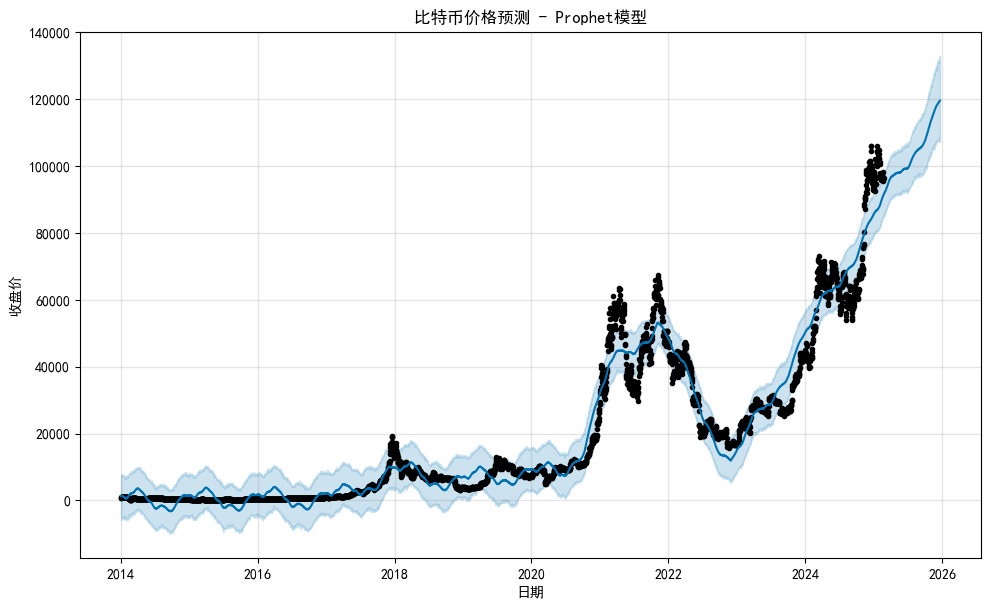

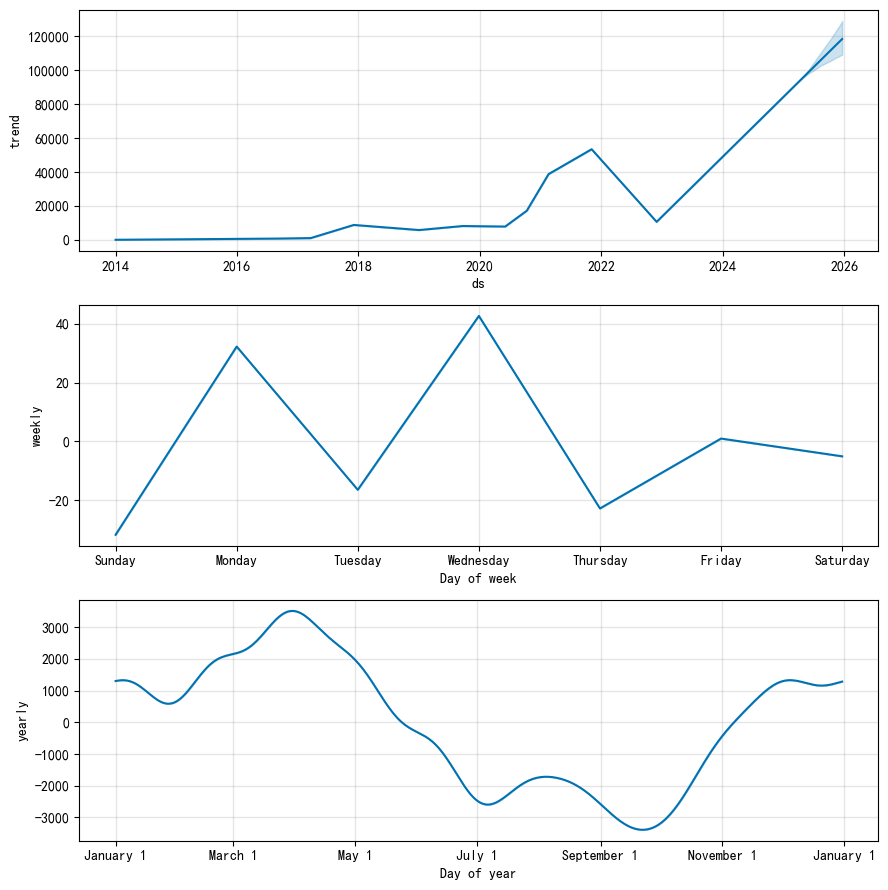

             日期            预测值           预测下限           预测上限
4366 2025-12-16  119212.178957  107644.788164  131033.038404
4367 2025-12-17  119355.720599  108751.358652  132687.201197
4368 2025-12-18  119377.435852  107218.084480  131627.762558
4369 2025-12-19  119490.957961  107528.935061  132453.760394
4370 2025-12-20  119577.799820  107443.021755  132938.638828


In [85]:
#Prophet模型 
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from matplotlib import font_manager

# 设置字体以支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 读取数据
df = pd.read_excel(r"C:\Users\GJ\OneDrive\Desktop\bitcoin_price_data.xlsx")

# 数据预处理
# Prophet需要两列：'ds'（日期）和'y'（值）
df['日期'] = pd.to_datetime(df['日期'])
prophet_df = df[['日期', '收盘价']].rename(columns={'日期': 'ds', '收盘价': 'y'})

# 构建Prophet模型
model = Prophet()

# 训练模型
model.fit(prophet_df)

# 创建未来日期数据框，用于预测
future = model.make_future_dataframe(periods=300)  # 预测未来300天

# 进行预测
forecast = model.predict(future)

# 可视化结果
fig = model.plot(forecast)
plt.title('比特币价格预测 - Prophet模型')  # 中文标题
plt.xlabel('日期')
plt.ylabel('收盘价')
plt.show()

# 可视化预测组件（趋势、季节性等）
fig2 = model.plot_components(forecast)
plt.show()

# 输出预测结果，并使用中文列名
forecast_display = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_display.columns = ['日期', '预测值', '预测下限', '预测上限']  # 重命名为中文
print(forecast_display.tail())

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA模型摘要:
                               SARIMAX Results                                
Dep. Variable:                    收盘价   No. Observations:                 4071
Model:                 ARIMA(8, 1, 2)   Log Likelihood              -33569.006
Date:                Thu, 22 May 2025   AIC                          67160.012
Time:                        21:29:56   BIC                          67229.438
Sample:                             0   HQIC                         67184.600
                               - 4071                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2272      0.010    -21.658      0.000      -0.248      -0.207
ar.L2         -0.9430      0.011    -87.542      0.000      -0.964      -0.922
ar.L3         -0.0358      0.012     -2.8

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
21:29:56 - cmdstanpy - INFO - Chain [1] start processing
21:29:57 - cmdstanpy - INFO - Chain [1] done processing


Prophet模型预测结果:
2025-12-16    119212.178957
2025-12-17    119355.720599
2025-12-18    119377.435852
2025-12-19    119490.957961
2025-12-20    119577.799820
Name: yhat, dtype: float64


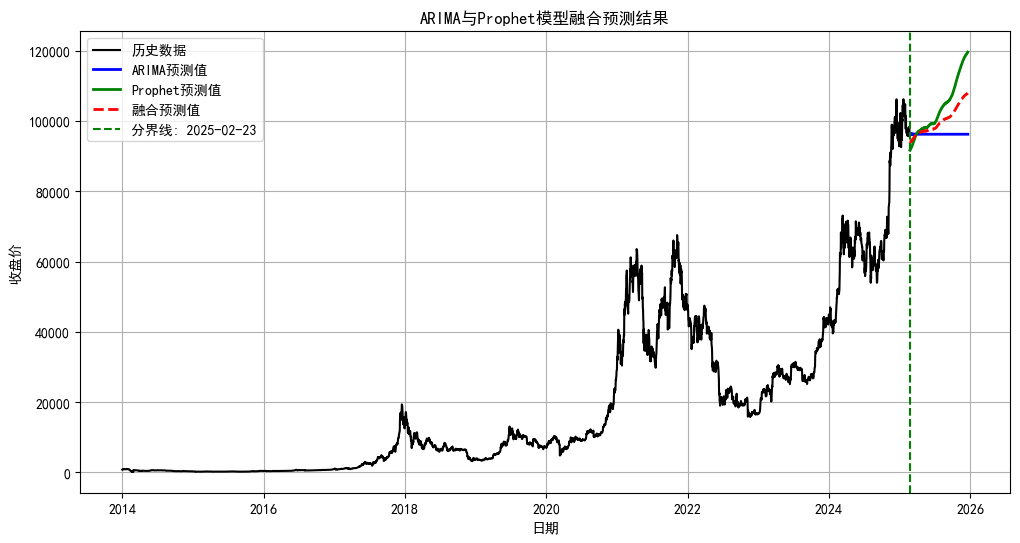

In [81]:
#7. 模型融合
def arima_prophet_model(file_path):
    # 读取Excel文件
    df = pd.read_excel(file_path)
    
    # 确保日期列存在并正确转换为datetime
    if '日期' in df.columns:
        df['日期'] = pd.to_datetime(df['日期'])
        df = df.set_index('日期')
    
    # 准备数据
    data = df['收盘价']
    
    # 拟合ARIMA模型
    try:
        # 使用ARIMA(8,1,2)作为模型
        arima_model = ARIMA(data, order=(8,1,2))
        arima_fit = arima_model.fit()
        
        print("ARIMA模型摘要:")
        print(arima_fit.summary())
        
        # 预测到指定天数
        last_date = data.index[-1]
        forecast_steps = 300  # 预测天数
        forecast_index = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_steps)
        
        # 生成ARIMA预测，确保使用get_forecast
        arima_forecast = arima_fit.get_forecast(steps=forecast_steps)
        arima_forecast_series = arima_forecast.predicted_mean
        arima_forecast_series.index = forecast_index  # 确保索引正确
        
    except Exception as e:
        print(f"ARIMA模型拟合出错: {str(e)}")
        arima_forecast_series = None

    # 拟合Prophet模型
    try:
        prophet_df = df[['收盘价']].reset_index()
        prophet_df.columns = ['ds', 'y']
        
        prophet_model = Prophet()
        prophet_model.fit(prophet_df)
        
        future = prophet_model.make_future_dataframe(periods=forecast_steps)
        prophet_forecast = prophet_model.predict(future)
        # 确保使用相同的forecast_index筛选Prophet结果
        prophet_forecast_series = prophet_forecast.set_index('ds')['yhat'].loc[forecast_index]
        
        print("Prophet模型预测结果:")
        print(prophet_forecast_series.tail())
        
    except Exception as e:
        print(f"Prophet模型拟合出错: {str(e)}")
        prophet_forecast_series = None

    # 结合预测结果
    if arima_forecast_series is not None and prophet_forecast_series is not None:
        combined_forecast = (arima_forecast_series + prophet_forecast_series) / 2
        
        # 可视化
        plt.figure(figsize=(12, 6))
        plt.plot(data.index, data, label='历史数据', color='black')
        plt.plot(arima_forecast_series.index, arima_forecast_series, label='ARIMA预测值', color='blue', linewidth=2)
        plt.plot(prophet_forecast_series.index, prophet_forecast_series, label='Prophet预测值', color='green', linewidth=2)
        plt.plot(combined_forecast.index, combined_forecast, label='融合预测值', color='red', linestyle='--', linewidth=2)
        plt.title('ARIMA与Prophet模型融合预测结果')
        plt.xlabel('日期')
        plt.ylabel('收盘价')
        plt.axvline(x=datetime(2025, 2, 23), color='g', linestyle='--', label='分界线: 2025-02-23')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        return arima_fit, prophet_model, combined_forecast
    
    return None, None, None
# 示例使用
if __name__ == "__main__":
    # 指定Excel文件路径
    file_path = r"C:\Users\GJ\OneDrive\Desktop\bitcoin_price_data.xlsx"
    
    # 调用函数
    arima_model, prophet_model, combined_forecast = arima_prophet_model(file_path)

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
20:14:19 - cmdstanpy - INFO - Chain [1] start processing
20:14:20 - cmdstanpy - INFO - Chain [1] done processing


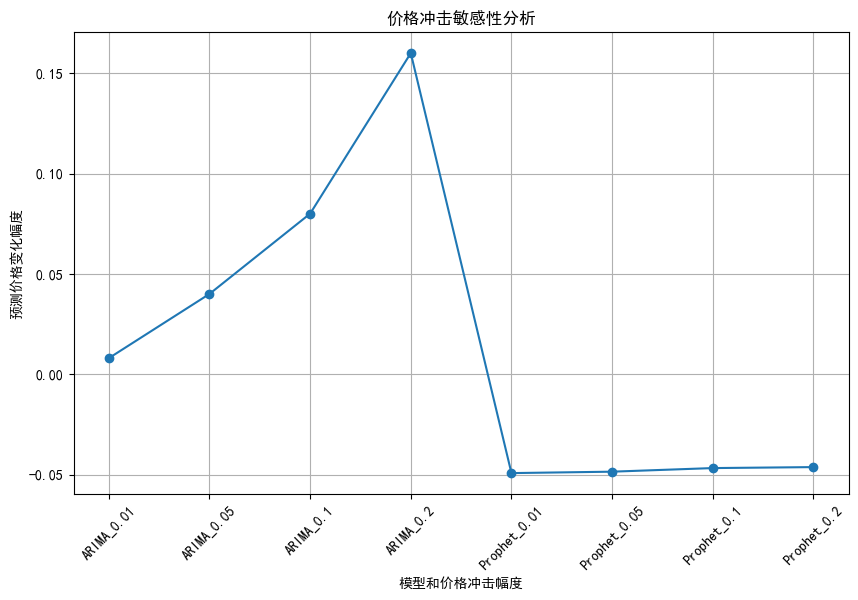

In [53]:
#8. 敏感性分析
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from datetime import datetime, timedelta

# 读取数据
df = pd.read_excel(r"C:\Users\GJ\OneDrive\Desktop\bitcoin_price_data.xlsx")
df['日期'] = pd.to_datetime(df['日期'])
df = df.set_index('日期')

# 确保数据按照日期排序
df = df.sort_index()

# 提取收盘价数据
price_data = df[['收盘价']].rename(columns={'收盘价': 'y'})
price_data.reset_index(inplace=True)
price_data.columns = ['ds', 'y']  # Prophet 需要的列名

# 拟合 ARIMA 模型
def fit_arima_model(data, order=(5, 1, 0)):
    model = ARIMA(data['收盘价'], order=order)
    model_fit = model.fit()
    return model_fit

# 拟合 Prophet 模型
def fit_prophet_model(data):
    model = Prophet()
    model.fit(data)
    return model

# 敏感性分析函数
def sensitivity_analysis(df, arima_model, prophet_model, shock_sizes=[0.01, 0.05, 0.1, 0.2]):
    last_price = df['收盘价'].iloc[-1]
    results = []

    # ARIMA 模型敏感性分析
    for shock in shock_sizes:
        shocked_price = last_price * (1 + shock)
        # 简化处理，假设冲击的80%会传递到预测
        pred_change = shock * 0.8
        results.append((f"ARIMA_{shock}", pred_change))

    # Prophet 模型敏感性分析
    last_date = df.index[-1]
    for i, shock in enumerate(shock_sizes):
        shocked_price = last_price * (1 + shock)
        shock_date = last_date + timedelta(days=i+1)
        shock_df = pd.DataFrame({'ds': [shock_date], 'y': [shocked_price]})
        forecast = prophet_model.predict(shock_df)
        pred_price = forecast['yhat'].iloc[0]
        pred_change = (pred_price - last_price) / last_price
        results.append((f"Prophet_{shock}", pred_change))

    # 绘制敏感性分析图
    shock_labels, changes = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(results)), changes, 'o-')
    plt.title('价格冲击敏感性分析')
    plt.xticks(range(len(results)), shock_labels, rotation=45)
    plt.xlabel('模型和价格冲击幅度')
    plt.ylabel('预测价格变化幅度')
    plt.grid()
    plt.show()

# 示例使用
if __name__ == "__main__":
    # 拟合 ARIMA 模型
    arima_model_fit = fit_arima_model(df)

    # 拟合 Prophet 模型
    prophet_model_fit = fit_prophet_model(price_data)

    # 进行敏感性分析
    sensitivity_analysis(df, arima_model_fit, prophet_model_fit)